### Now for all tests we're going to use the new task/test code added to `ip_diffim`.

Things still TBD for this are:
    
    1. check if there is a gradient that needs to be fit
    2. better estimate of starting parameters for gradient
    3. better estimate for staring flux when there's a strong gradient
    4. (DONE): separate parameters for pos- and neg- images?
    5. only fit background OUTSIDE footprint and dipole params INSIDE footprint?
    

somewhere else, do:
```
git clone https://github.com/lsst/ip_diffim.git
cd ip_diffim
source ~/lsstsw/setup.csh
#setup -t b1898 ip_diffim
#setup -k -r .
setup -t b1898 -r .
scons opt=3 -j 4 lib python
```

then you will want to add `$HOME/lsstsw/miniconda/lib/python2.7/site-packages` to your `PYTHONPATH` in order to be able to import `joblib` and friends.

now edit and run the code in here.

In [1]:
import sys
from collections import namedtuple

import numpy as np

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

import lmfit

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

In [2]:
## LSST imports:
import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim

Import DipoleTestUtils code from `$IP_DIFFIM_DIR/tests/testDipoleFitter.py` ...

/Users/dreiss/GIT_REPOS/ip_diffim/tests/testDipoleFitter.py
100.0
2.0
548011.0


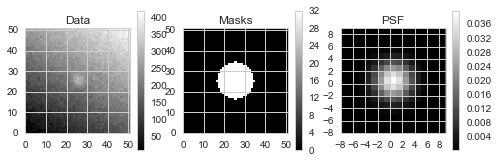

In [3]:
import imp, os
print os.getenv('IP_DIFFIM_DIR')+'/tests/testDipoleFitter.py'
dtUtils = imp.load_source('dtUtils', os.getenv('IP_DIFFIM_DIR')+'/tests/testDipoleFitter.py')
from lsst.ip.diffim import dipoleFitTask as dft

exposure, catalog = dtUtils.DipoleTestUtils.makeStarImage(w=51, h=51, xc=[25], yc=[25], flux=[2500], noise=10., 
                                                          gradientParams=(10., 3., 5., 0., 0., 0.))
dft.DipolePlotUtils.displayExposure(exposure, showPsf=True)
print exposure.getMaskedImage().getArrays()[2].mean()
print exposure.getPsf().computeShape().getDeterminantRadius()
print exposure.getMaskedImage().getArrays()[0].sum()

In [4]:
import time
print time.strftime("%d.%m.%Y")
print dft.DipoleFitAlgorithm.__private_version__

25.03.2016
0.0.2b


See [here](http://lsst-web.ncsa.illinois.edu/doxygen/x_releases_Summer2012DoxyDoc/afw_mask_planes.html) for afw mask info.

```
def showMask(msk, msg="???"):
    print "%-15s" % msg, " ".join(sorted([str(x) for x in msk.getMaskPlaneDict().items()]))

>>> dm = dipole.getMaskedImage().getMask()
>>> showMask(dm)  ## mask "5" == 2**5 == 32 is "DETECTED", is set. 
```


Default planes are 
```
## ???   ('BAD', 0) ('CR', 3) ('DETECTED', 5) ('DETECTED_NEGATIVE', 6) ('EDGE', 4) ('INTRP', 2) ('NO_DATA', 8) ('RHL', 9) ('SAT', 1) ('SUSPECT', 7)
```

For detection, mask "5" == 2**5 == 32 is "DETECTED", is set. 

(51, 51)
200.0
100.0
100.0


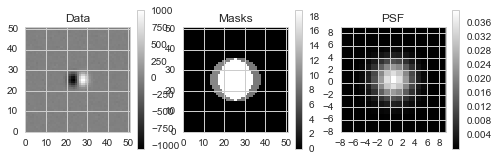

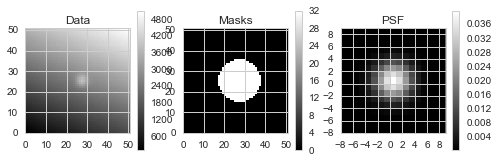

In [5]:
dipole, (posImage, posCatalog), (negImage, negCatalog) = \
                dtUtils.DipoleTestUtils.makeDipoleImage(w=51, h=51, flux=[30000.], xcenPos=[27.], ycenPos=[25.], 
                                                        xcenNeg=[23.], ycenNeg=[25.],
                                                        gradientParams=(100., 30., 70., 0., 0., 0.))
dft.DipolePlotUtils.displayExposure(dipole, showPsf=True)
dft.DipolePlotUtils.displayExposure(posImage, showPsf=True)
print dipole.getMaskedImage().getArrays()[0].shape
print dipole.getMaskedImage().getArrays()[2].mean()
print posImage.getMaskedImage().getArrays()[2].mean()
print negImage.getMaskedImage().getArrays()[2].mean()

FOOTPRINT CENTER: 25 28
FOOTPRINT CENTER: 25 22


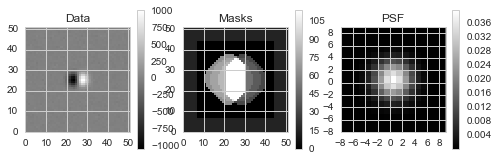

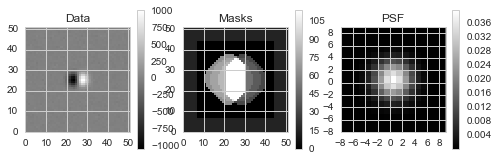

In [6]:
#s = detectDipoleSources(dipole, verbose=False)
s = dtUtils.DipoleTestUtils.detectDipoleSources(dipole, doMerge=True)

for pk in s[0].getFootprint().getPeaks():
    print 'FOOTPRINT CENTER:', pk.getIy(), pk.getIx()

dft.DipolePlotUtils.displayExposure(dipole, showPsf=True)

In [7]:
## I think this is the meat of the ip_diffim code that runs the measurement. 
def measureDipole(s, exposure, dipoleCentroid):
    msConfig = ipDiffim.DipoleMeasurementConfig()
    schema = afwTable.SourceTable.makeMinimalSchema()
    schema.addField("centroid_x", type=float)
    schema.addField("centroid_y", type=float)
    schema.addField("centroid_flag", type='Flag')
    task = ipDiffim.DipoleMeasurementTask(schema, config=msConfig)
    measCat = afwTable.SourceCatalog(schema)
    measCat.defineCentroid("centroid")
    source = measCat.addNew()
    source.set("centroid_x", dipoleCentroid[0])
    source.set("centroid_y", dipoleCentroid[1])
    source.setFootprint(s.getFootprint())

    #print 'DIPOLE: ', source.get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
    # Then run the default SFM task.  Results not checked
    task.run(measCat, exposure)
    return measCat[0] 

#from collections import namedtuple
#resultsOutput = namedtuple('resultsOutput', 
#        #'inputCentroidX inputCentroidY inputSeparation inputRotation inputFlux inputPosCentroidX inputPosCentroidY inputNegCentroidX inputNegCentroidY psfFitPosCentroidX psfFitPosCentroidY psfFitNegCentroidX psfFitNegCentroidY psfFitPosFlux psfFitNegFlux psfFitCentroidX psfFitCentroidY psfFitOrientation psfFitSignaltoNoise')
#        'psfFitPosCentroidX psfFitPosCentroidY psfFitNegCentroidX psfFitNegCentroidY psfFitPosFlux psfFitNegFlux psfFitCentroidX psfFitCentroidY psfFitOrientation psfFitSignaltoNoise')
resultsOutput = dft.DipoleFitAlgorithm.resultsOutput

def fitDipole_ipDiffim(exposure, sCat):    
    pks = sCat.getFootprint().getPeaks()
    pk1 = pks[0].getF() #)[::-1]  ## need to switch x,y ?? No.
    pk2 = pks[1].getF() #)[::-1]

    dipoleCentroid = (np.int(np.mean([pk1[0], pk2[0]])), np.int(np.mean([pk1[1], pk2[1]])))
    result = measureDipole(sCat, exposure, dipoleCentroid=dipoleCentroid)
    
    ## provides (S/N, position, orientation) of measured dipoles
    dpAnalysis = ipDiffim.DipoleAnalysis()
    sn, centroid, orientation = dpAnalysis(result)

    #rotAngRad = rotAngle / 180. * np.pi
    #xp, yp = xc + separation/2. * np.cos(rotAngRad), yc + separation/2. * np.sin(rotAngRad)
    #xn, yn = xc - separation/2. * np.cos(rotAngRad), yc - separation/2. * np.sin(rotAngRad)
    
    out = resultsOutput(##xc, yc, separation, rotAngle, flux, xp, yp, xn, yn, 
        result.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), result.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"),
        result.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), result.get("ip_diffim_PsfDipoleFlux_neg_centroid_y"),
        result.get("ip_diffim_PsfDipoleFlux_pos_flux"), result.get("ip_diffim_PsfDipoleFlux_neg_flux"),
        0., 0., centroid.getX(), centroid.getY(), orientation, sn, 0., 0.)
    return out

(3, 31, 36)


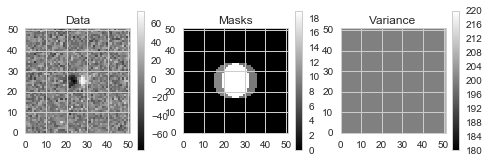

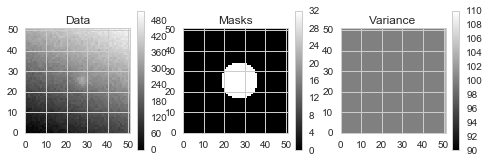

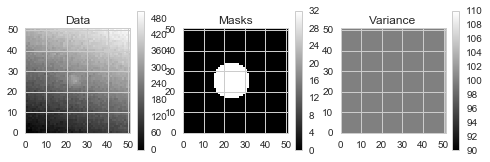

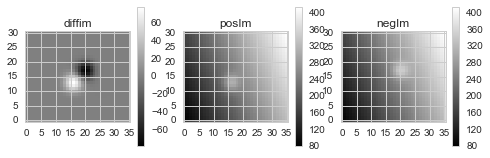

In [8]:
diffim, (posImage, posCatalog), (negImage, negCatalog) = \
    dtUtils.DipoleTestUtils.makeDipoleImage(w=51, h=51, flux=[2000.], xcenPos=[27.], ycenPos=[25.], 
                                            xcenNeg=[23.], ycenNeg=[25.],
                                            gradientParams=(1., 3., 7., 0., 0., 0.))
s = dtUtils.DipoleTestUtils.detectDipoleSources(dipole, doMerge=True)

# w, h = diffim.getWidth(), diffim.getHeight()
# print w, h
# y, x = np.mgrid[:w, :h]
# in_x = np.array([x, y])

dft.DipolePlotUtils.displayExposure(diffim)
dft.DipolePlotUtils.displayExposure(posImage)
dft.DipolePlotUtils.displayExposure(negImage)

fp = s[0].getFootprint()
psf = diffim.getPsf()

arr = dft.DipoleFitAlgorithm.genDipoleModel(None, flux=2000., xcenPos=23., ycenPos=23., 
                                            xcenNeg=27., ycenNeg=27., b=1., x1=3., y1=7., 
                                            psf=psf, footprint=fp, rel_weight=0.5)
print arr.shape
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
dft.DipolePlotUtils.display2dArray(arr[0,:], title='diffim')
plt.subplot(1, 3, 2)
dft.DipolePlotUtils.display2dArray(arr[1,:], title='posIm')
plt.subplot(1, 3, 3)
dft.DipolePlotUtils.display2dArray(arr[2,:], title='negIm')

 - Adding parameter for hint "xcenPos"
 - Adding parameter for hint "ycenPos"
 - Adding parameter for hint "xcenNeg"
 - Adding parameter for hint "ycenNeg"
 - Adding parameter for hint "flux"
 - Adding parameter for hint "b"
 - Adding parameter for hint "x1"
 - Adding parameter for hint "y1"
 - Adding parameter "flux"
 - Adding parameter "xcenPos"
 - Adding parameter "ycenPos"
 - Adding parameter "xcenNeg"
 - Adding parameter "ycenNeg"
 - Adding parameter "b"
 - Adding parameter "x1"
 - Adding parameter "y1"
[[Model]]
    Model(genDipoleModel)
[[Fit Statistics]]
    # function evals   = 121
    # data points      = 3348
    # variables        = 8
    chi-square         = 263660.912
    reduced chi-square = 78.940
[[Variables]]
    xcenPos:   27.0837543 +/- 0.101632 (0.38%) (init= 28)
    ycenPos:   25.0382335 +/- 0.085429 (0.34%) (init= 25)
    xcenNeg:   23.1072078 +/- 0.101039 (0.44%) (init= 22)
    ycenNeg:   24.9692682 +/- 0.084563 (0.34%) (init= 25)
    flux:      1945.43035 +/- 5

/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/model.py:459: UserWarning: The keyword argument footprint does notmatch any arguments of the model function.It will be ignored.
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/model.py:459: UserWarning: The keyword argument rel_weight does notmatch any arguments of the model function.It will be ignored.
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/model.py:459: UserWarning: The keyword argument psf does notmatch any arguments of the model function.It will be ignored.



resultsOutput(psfFitPosCentroidX=27.083754379093939, psfFitPosCentroidY=25.038233570389387, psfFitNegCentroidX=23.107207886917813, psfFitNegCentroidY=24.969268226820656, psfFitPosFlux=1945.4303523706335, psfFitNegFlux=-1945.4303523706335, psfFitPosFluxSigma=59.386767030624597, psfFitNegFluxSigma=59.386767030624597, psfFitCentroidX=25.095481133005876, psfFitCentroidY=25.00375089860502, psfFitOrientation=0.9935825038308429, psfFitSignaltoNoise=31.32904631702117, psfFitChi2=263660.91229752777, psfFitRedChi2=78.940392903451425)
 - Adding parameter for hint "xcenPos"
 - Adding parameter for hint "ycenPos"
 - Adding parameter for hint "xcenNeg"
 - Adding parameter for hint "ycenNeg"
 - Adding parameter for hint "flux"
 - Adding parameter "flux"
 - Adding parameter "xcenPos"
 - Adding parameter "ycenPos"
 - Adding parameter "xcenNeg"
 - Adding parameter "ycenNeg"
[[Model]]
    Model(genDipoleModel)
[[Fit Statistics]]
    # function evals   = 55
    # data points      = 1116
    # variables  

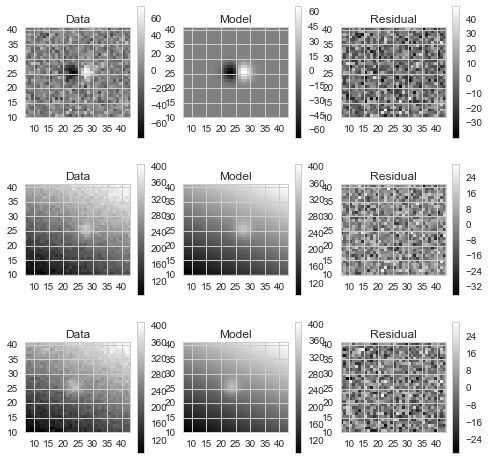

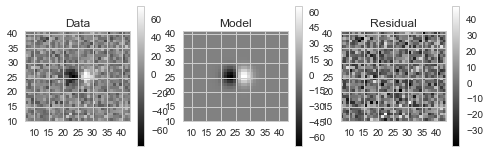

In [9]:
result = dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, verbose=True, 
                                              rel_weight=0.5, separateNegParams=False, display=True)
print '\n', result
result = dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, verbose=True, 
                                              rel_weight=0., separateNegParams=False, display=True)
print result

Looks like primary reason for long run time of ipDiffim fitter is the number of function evaluations (on the order of $\sim 150$, vs. $\sim 50$ or less for the python fitter).

Need to look into strategies to bring that down. Improving starting flux values helps a bit (brings it down from $\sim 200$), but 
tweaking parameter constraints or fit tolerance does not seem to do much.

In [10]:
result = fitDipole_ipDiffim(exposure=dipole, sCat=s[0])
print result
%timeit result = fitDipole_ipDiffim(exposure=dipole, sCat=s[0])

resultsOutput(psfFitPosCentroidX=27.013578703206036, psfFitPosCentroidY=25.012704156391546, psfFitNegCentroidX=22.986046195465978, psfFitNegCentroidY=25.003658511683387, psfFitPosFlux=29861.518808695473, psfFitNegFlux=-29913.67787851288, psfFitPosFluxSigma=0.0, psfFitNegFluxSigma=0.0, psfFitCentroidX=24.999812449336005, psfFitCentroidY=25.008181334037467, psfFitOrientation=1.56855 rad, psfFitSignaltoNoise=252.93972831093973, psfFitChi2=0.0, psfFitRedChi2=0.0)
10 loops, best of 3: 56.4 ms per loop


resultsOutput(psfFitPosCentroidX=27.095707852925493, psfFitPosCentroidY=25.008261336989307, psfFitNegCentroidX=23.09928622315001, psfFitNegCentroidY=24.999997958896365, psfFitPosFlux=1952.6665573417517, psfFitNegFlux=-1952.6665573417517, psfFitPosFluxSigma=0, psfFitNegFluxSigma=0, psfFitCentroidX=25.097497038037751, psfFitCentroidY=25.004129647942836, psfFitOrientation=0.11846998599649713, psfFitSignaltoNoise=31.445577551574683, psfFitChi2=423382.75591739791, psfFitRedChi2=126.76130416688561)
10 loops, best of 3: 46.3 ms per loop
10 loops, best of 3: 31.2 ms per loop
10 loops, best of 3: 20.9 ms per loop
100 loops, best of 3: 13.7 ms per loop


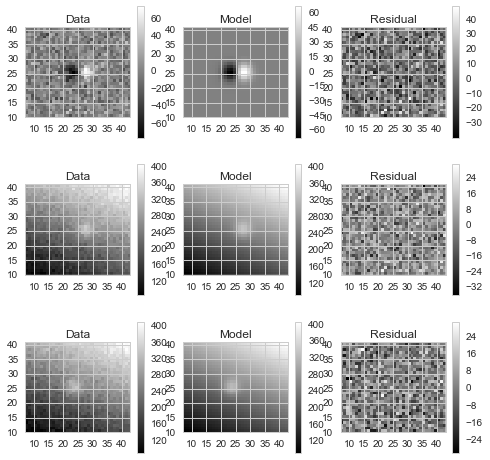

In [11]:
result = dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, rel_weight=1.,
                                              separateNegParams=False, verbose=False, display=True)
print result
#%timeit fitDipole_new((diffim, posImage, negImage), s, verbose=False, rel_weight=0., display=False)  ## test the timings of new vs. old
%timeit dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, rel_weight=1., \
                                             separateNegParams=False, verbose=False, display=False)
%timeit dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, rel_weight=1., \
                                             separateNegParams=False, verbose=False, display=False, tol=1e-5)
%timeit dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, rel_weight=0., \
                                             separateNegParams=False, verbose=False, display=False)
%timeit dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, rel_weight=0., \
                                             separateNegParams=False, verbose=False, display=False, tol=1e-5)

In [12]:
resultsOutput2 = namedtuple('resultsOutput2',
    ['inputCentroidX', 'inputCentroidY', 'inputSeparation', 'inputRotation', 'inputFlux', 'inputPosCentroidX',
     'inputPosCentroidY', 'inputNegCentroidX', 'inputNegCentroidY', 'psfFitPosCentroidX', 'psfFitPosCentroidY',
     'psfFitNegCentroidX', 'psfFitNegCentroidY', 'psfFitPosFlux', 'psfFitNegFlux', 'psfFitCentroidX', 
     'psfFitCentroidY', 'psfFitOrientation', 'psfFitSignaltoNoise'])

def genDipoleAndFitBothWays(w=51, h=51, xc=25., yc=25., separation=2., rotAngle=324., psfSigma=2., 
                            flux=30000., noise=10., rel_weight=0.1, tol=1e-7, 
                            gradientParams=(1., 3., 7., 0., 0., 0.), ## dflt. background gradient params to use for all tests below
                            verbose=False, display=False):

    rotAngRad = rotAngle / 180. * np.pi
    sep = separation / 2.
    xcenPos, ycenPos = xc+sep*np.cos(rotAngRad), yc+sep*np.sin(rotAngRad)
    xcenNeg, ycenNeg = xc-sep*np.cos(rotAngRad), yc-sep*np.sin(rotAngRad)
    
    dipole, (posImage, posCatalog), (negImage, negCatalog) = \
        dtUtils.DipoleTestUtils.makeDipoleImage(w=w, h=h, flux=[flux], xcenPos=[xcenPos], ycenPos=[ycenPos], 
                                                xcenNeg=[xcenNeg], ycenNeg=[ycenNeg], \
                                                psfSigma=psfSigma, noise=noise, \
                                                gradientParams=gradientParams)

    resultNA = resultsOutput2(xc, yc, separation, rotAngle, flux, xcenPos, ycenPos, xcenNeg, ycenNeg,
                              np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    result1 = result2 = resultNA
    s = None

    try:
        s = dtUtils.DipoleTestUtils.detectDipoleSources(dipole, doMerge=True)
        ## Note that the new code can handle a footprint with a single peak but for better comparison with
        ## old code, let's just raise here.
        #if len(s[0].getFootprint().getPeaks()) <= 1:
        #    raise Exception

    except Exception as err:
        #print 'Uh oh! (1):', err
        return {'old': result2, 'new': result1, 'dipole': dipole}
    
    try:
        r1 = fitDipole_ipDiffim(exposure=dipole, sCat=s[0])
        result1 = resultsOutput2(xc, yc, separation, rotAngle, flux, xcenPos, ycenPos, xcenNeg, ycenNeg,
                            r1.psfFitPosCentroidX, r1.psfFitPosCentroidY, r1.psfFitNegCentroidX,
                            r1.psfFitNegCentroidY, r1.psfFitPosFlux, r1.psfFitNegFlux, r1.psfFitCentroidX,
                            r1.psfFitCentroidY, r1.psfFitOrientation, r1.psfFitSignaltoNoise)
    except Exception as err:
        #print 'Uh oh! (2):', err
        pass
    
    try:
        r2 = dft.DipoleFitAlgorithm.fitDipole_new(dipole, s[0], posImage, negImage, rel_weight=rel_weight,
                                              separateNegParams=False, verbose=False, display=False)
        result2 = resultsOutput2(xc, yc, separation, rotAngle, flux, xcenPos, ycenPos, xcenNeg, ycenNeg,
                            r2.psfFitPosCentroidX, r2.psfFitPosCentroidY, r2.psfFitNegCentroidX,
                            r2.psfFitNegCentroidY, r2.psfFitPosFlux, r2.psfFitNegFlux, r1.psfFitCentroidX,
                            r2.psfFitCentroidY, r2.psfFitOrientation, r2.psfFitSignaltoNoise)
    except Exception as err:
        #print 'Uh oh! (3):', err
        pass

    return {'old': result1, 'new': result2, 'dipole': dipole, 'posImage': posImage, 'negImage': negImage}

resultsOutput2(inputCentroidX=25.0, inputCentroidY=25.0, inputSeparation=2.0, inputRotation=324.0, inputFlux=1000.0, inputPosCentroidX=25.809016994374947, inputPosCentroidY=24.412214747707527, inputNegCentroidX=24.190983005625053, inputNegCentroidY=25.587785252292473, psfFitPosCentroidX=25.722692598260185, psfFitPosCentroidY=24.48397939674594, psfFitNegCentroidX=24.19385244234866, psfFitNegCentroidY=25.5738215677488, psfFitPosFlux=1064.56025591918, psfFitNegFlux=-1086.6759510710683, psfFitCentroidX=24.958272520304423, psfFitCentroidY=25.028900482247373, psfFitOrientation=2.1901 rad, psfFitSignaltoNoise=8.9276250978757563)
resultsOutput2(inputCentroidX=25.0, inputCentroidY=25.0, inputSeparation=2.0, inputRotation=324.0, inputFlux=1000.0, inputPosCentroidX=25.809016994374947, inputPosCentroidY=24.412214747707527, inputNegCentroidX=24.190983005625053, inputNegCentroidY=25.587785252292473, psfFitPosCentroidX=25.822140284319786, psfFitPosCentroidY=24.427955403754268, psfFitNegCentroidX=24.1

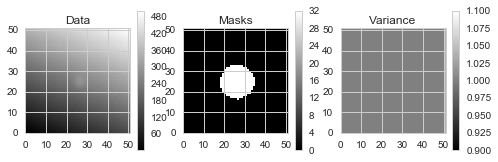

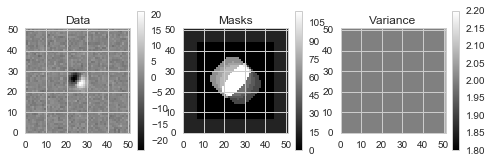

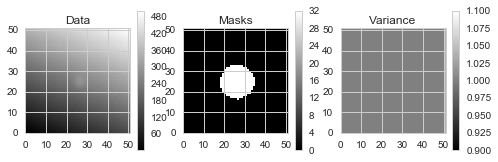

In [13]:
result = genDipoleAndFitBothWays(w=51, h=51, xc=25., yc=25., separation=2., rotAngle=324., psfSigma=2., 
                         flux=1000., noise=1., rel_weight=1.0, verbose=False, display=True)
print result['old']
print result['new']
dft.DipolePlotUtils.displayExposure(result['dipole'])
dft.DipolePlotUtils.displayExposure(result['posImage'])

### First test dipoles of varying separation (same orientation, same flux)

NOTE all of these results below will look better than in `8f.` because we are using `rel_weight = 0.5` by default (instead of `rel_weight = 0.1` in `8g`.

In [14]:
## Is there an easier way to do this (generate named tuple from function variable names)?
varNames = genDipoleAndFitBothWays.__code__.co_varnames[:genDipoleAndFitBothWays.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

#orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)[::-1]
n_reps = 100

inputs = [varTuple(w=51, h=51, xc=25., yc=25., psfSigma=2.0, separation=sep, rotAngle=0., \
                   flux=1000., noise=1., tol=1e-7, rel_weight=0.5, verbose=False, display=False, \
                  gradientParams=(1., 3., 7.)) for i in xrange(n_reps) for sep in separations]
print len(inputs)

def processInput(i):
    output = genDipoleAndFitBothWays(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfSigma=i.psfSigma,
                                     separation=i.separation, rotAngle=i.rotAngle, flux=i.flux, 
                                     noise=i.noise, tol=i.tol, rel_weight=i.rel_weight, 
                                     gradientParams=i.gradientParams,
                                     verbose=False, display=False)
    if output['new'] is not None:
        output['new'] = output['new']._asdict()
    if output['old'] is not None:
        output['old'] = output['old']._asdict()
    return {'old': output['old'], 'new': output['new']} ## don't need the images returned

num_cores = multiprocessing.cpu_count() / 2
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
#results = [processInput(i) for i in inputs]

2400


(22, 28)

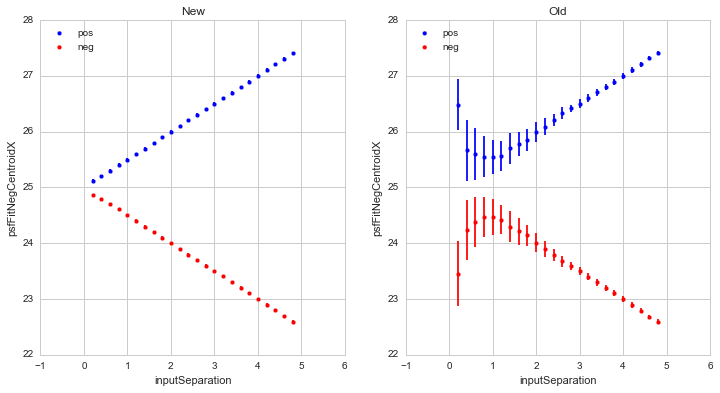

In [15]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results])
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosCentroidX', kind='scatter', yerr=tmp_df2['psfFitPosCentroidX'], 
                 color='blue', label='pos', ax=axes[0])
tmp_df.plot(x='inputSeparation', y='psfFitNegCentroidX', kind='scatter', yerr=tmp_df2['psfFitNegCentroidX'], 
            color='red', label='neg', ax=ax)

df = pd.DataFrame([res['old'] for res in results])
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosCentroidX', kind='scatter', yerr=tmp_df2['psfFitPosCentroidX'], 
                 color='blue', label='pos', ax=axes[1])
tmp_df.plot(x='inputSeparation', y='psfFitNegCentroidX', kind='scatter', yerr=tmp_df2['psfFitNegCentroidX'], 
            color='red', label='neg', ax=ax)

axes[0].set_title('New')
axes[0].set_ylim([22,28])
axes[1].set_title('Old')
axes[0].set_ylim([22,28])

(70, 110)

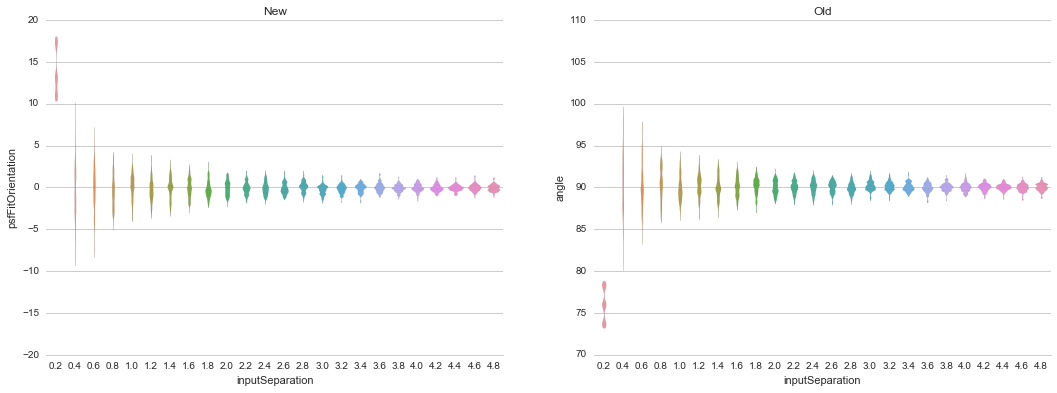

In [16]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results])
sns.violinplot(x="inputSeparation", y="psfFitOrientation", data=df, inner="quart", cut=True, linewidth=0.1, 
               bw=0.2, ax=axes[0])
sns.despine(left=True)

df = pd.DataFrame([res['old'] for res in results])
df['angle'] = pd.Series([float(i * 180. / np.pi) for i in df.psfFitOrientation])
sns.violinplot(x="inputSeparation", y="angle", data=df, inner="quart", cut=True, linewidth=0.1, bw=0.2, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-20,20])
axes[1].set_title('Old')
axes[1].set_ylim([70,110])

(0, 5)

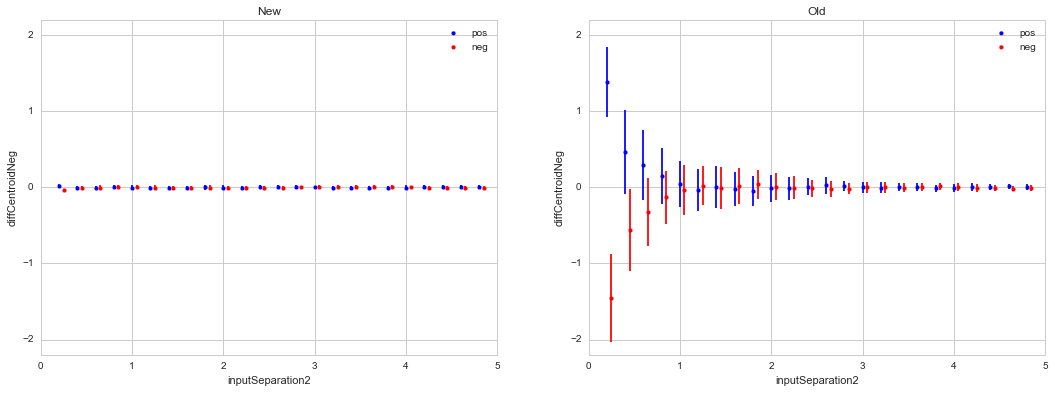

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results])
df['diffCentroidPos'] = df.psfFitPosCentroidX - df.inputPosCentroidX
df['diffCentroidNeg'] = df.psfFitNegCentroidX - df.inputNegCentroidX
df['inputSeparation2'] = df.inputSeparation + 0.05
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='diffCentroidPos', kind='scatter', yerr=tmp_df2['diffCentroidPos'], 
                 color='blue', label='pos', ax=axes[0])
tmp_df.plot(x='inputSeparation2', y='diffCentroidNeg', kind='scatter', yerr=tmp_df2['diffCentroidNeg'], 
            color='red', label='neg', ax=ax)

df = pd.DataFrame([res['old'] for res in results])
df['diffCentroidPos'] = df.psfFitPosCentroidX - df.inputPosCentroidX
df['diffCentroidNeg'] = df.psfFitNegCentroidX - df.inputNegCentroidX
df['inputSeparation2'] = df.inputSeparation + 0.05
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='diffCentroidPos', kind='scatter', yerr=tmp_df2['diffCentroidPos'], 
                 color='blue', label='pos', ax=axes[1])
tmp_df.plot(x='inputSeparation2', y='diffCentroidNeg', kind='scatter', yerr=tmp_df2['diffCentroidNeg'], 
            color='red', label='neg', ax=ax)

axes[0].set_title('New')
axes[0].set_ylim([-2.2,2.2]); axes[0].set_xlim([0,5])
axes[1].set_title('Old')
axes[1].set_ylim([-2.2,2.2]); axes[1].set_xlim([0,5])

(-8000, 8000)

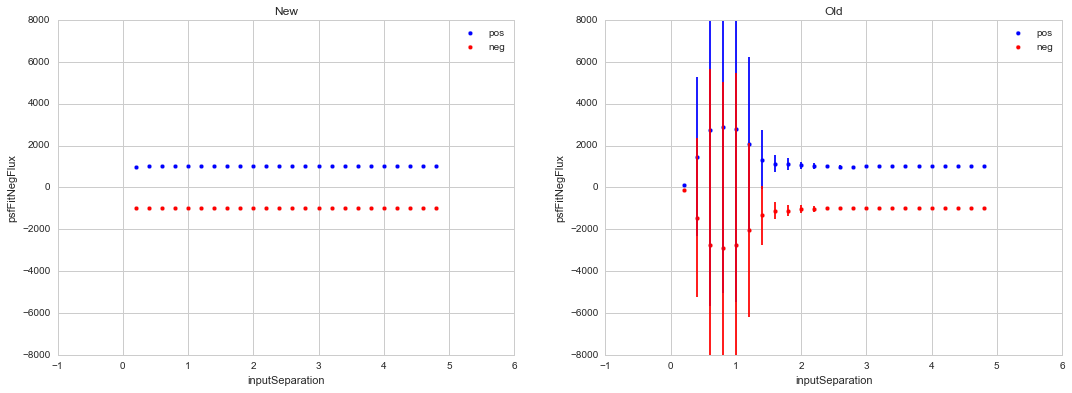

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results])
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosFlux', kind='scatter', yerr=tmp_df2['psfFitPosFlux'], 
                 color='blue', label='pos', ax=axes[0])
tmp_df.plot(x='inputSeparation', y='psfFitNegFlux', kind='scatter', yerr=tmp_df2['psfFitNegFlux'], 
            color='red', label='neg', ax=ax)

df = pd.DataFrame([res['old'] for res in results])
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosFlux', kind='scatter', yerr=tmp_df2['psfFitPosFlux'], 
                 color='blue', label='pos', ax=axes[1])
tmp_df.plot(x='inputSeparation', y='psfFitNegFlux', kind='scatter', yerr=tmp_df2['psfFitNegFlux'], 
            color='red', label='neg', ax=ax)

axes[0].set_title('New')
axes[0].set_ylim([-8000,8000])
axes[1].set_title('Old')
axes[1].set_ylim([-8000,8000])

(-1000, 3000)

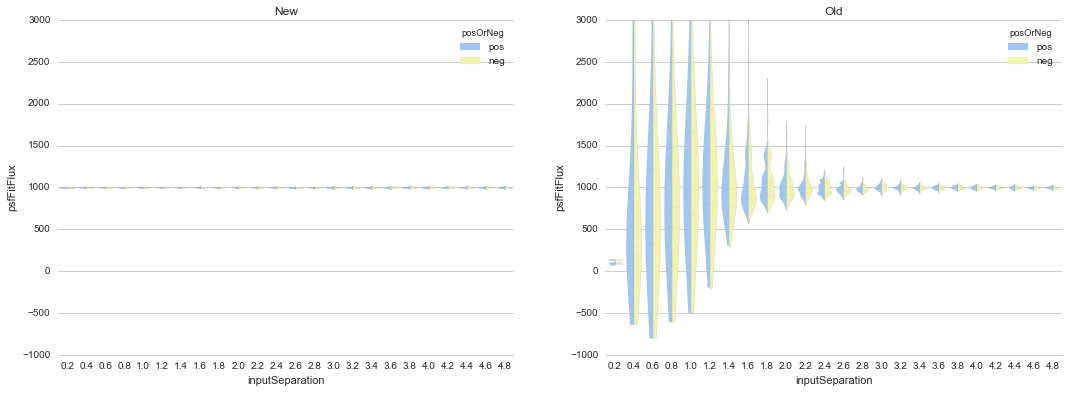

In [19]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.1, bw=0.2, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df1.loc[(df1.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
df2.loc[(df2.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.1, bw=0.2, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-1000,3000])
axes[1].set_title('Old')
axes[1].set_ylim([-1000,3000])

Try it again, this time setting different orientations as well. Next time we'll also test it as a function of scaling (source flux).

## Different orientations AND separations

In [20]:
varNames = genDipoleAndFitBothWays.__code__.co_varnames[:genDipoleAndFitBothWays.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)
n_reps = 10

inputs = [varTuple(w=51, h=51, xc=25., yc=25., psfSigma=2.0, separation=sep, rotAngle=rot, 
                    flux=1000., noise=1., tol=1e-7, rel_weight=0.5, 
                   gradientParams=(1., 3., 7.), verbose=False, display=False) 
          for i in xrange(n_reps) for rot in orientations for sep in separations]
print len(inputs)

def processInput(i):
    output = genDipoleAndFitBothWays(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfSigma=i.psfSigma, 
                                     separation=i.separation, rotAngle=i.rotAngle, flux=i.flux, 
                                     rel_weight=i.rel_weight, noise=i.noise, tol=i.tol, 
                                     gradientParams=i.gradientParams, verbose=False, display=False)
    if output['new'] is not None:
        output['new'] = output['new']._asdict()
    if output['old'] is not None:
        output['old'] = output['old']._asdict()
    return {'old': output['old'], 'new': output['new']} ## don't need the images returned

num_cores = multiprocessing.cpu_count() / 2
results2 = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
#results2 = [processInput(i) for i in inputs]

2400


(0, 5)

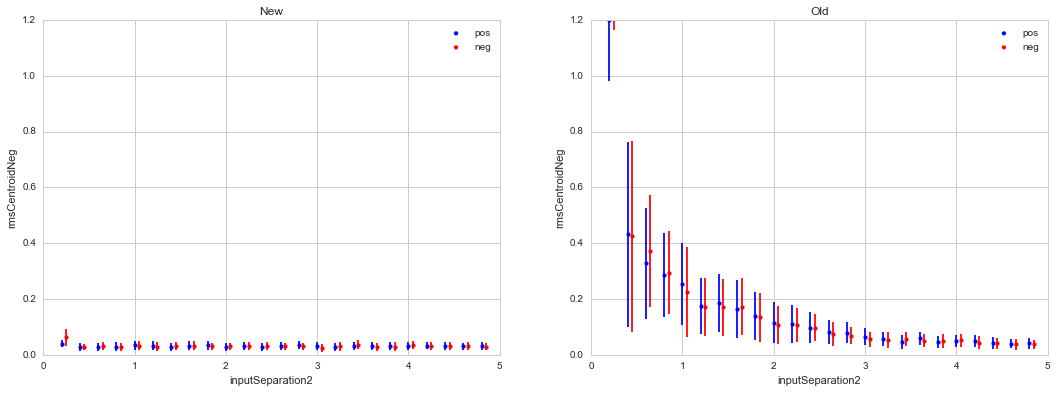

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results2])
df['rmsCentroidPos'] = np.sqrt((df.inputPosCentroidX - df.psfFitPosCentroidX)**2. + \
                               (df.inputPosCentroidY - df.psfFitPosCentroidY)**2.)

df['rmsCentroidNeg'] = np.sqrt((df.inputNegCentroidX - df.psfFitNegCentroidX)**2. + \
                               (df.inputNegCentroidY - df.psfFitNegCentroidY)**2.)
df['inputSeparation2'] = df.inputSeparation + 0.05
tmp_df = df.groupby('inputSeparation').median()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').mad() * 1.
ax = tmp_df.plot(x='inputSeparation', y='rmsCentroidPos', kind='scatter', yerr=tmp_df2['rmsCentroidPos'], 
                 color='blue', label='pos', ax=axes[0])
tmp_df.plot(x='inputSeparation2', y='rmsCentroidNeg', kind='scatter', yerr=tmp_df2['rmsCentroidNeg'], 
            color='red', label='neg', ax=ax)

df = pd.DataFrame([res['old'] for res in results2])
df['rmsCentroidPos'] = np.sqrt((df.inputPosCentroidX - df.psfFitPosCentroidX)**2. + \
                               (df.inputPosCentroidY - df.psfFitPosCentroidY)**2.)
df['rmsCentroidNeg'] = np.sqrt((df.inputNegCentroidX - df.psfFitNegCentroidX)**2. + \
                               (df.inputNegCentroidY - df.psfFitNegCentroidY)**2.)
df['inputSeparation2'] = df.inputSeparation + 0.05
tmp_df = df.groupby('inputSeparation').median()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').mad() * 1.
ax = tmp_df.plot(x='inputSeparation', y='rmsCentroidPos', kind='scatter', yerr=tmp_df2['rmsCentroidPos'], 
                 color='blue', label='pos', ax=axes[1])
tmp_df.plot(x='inputSeparation2', y='rmsCentroidNeg', kind='scatter', yerr=tmp_df2['rmsCentroidNeg'], 
            color='red', label='neg', ax=ax)

axes[0].set_title('New')
axes[0].set_ylim([0.,1.2]); axes[0].set_xlim([0, 5])
axes[1].set_title('Old')
axes[1].set_ylim([0.,1.2]); axes[1].set_xlim([0, 5])

(-0.1, 2.0)

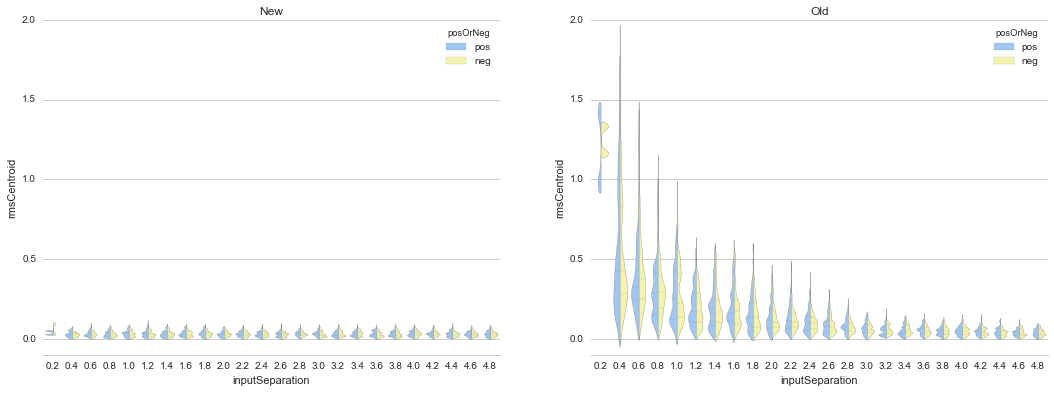

In [22]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results2])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['rmsCentroid'] = np.sqrt((df2.inputNegCentroidX - df2.psfFitNegCentroidX)**2. + \
                               (df2.inputNegCentroidY - df2.psfFitNegCentroidY)**2.)   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="rmsCentroid", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.3, bw=0.2, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results2])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['rmsCentroid'] = np.sqrt((df2.inputNegCentroidX - df2.psfFitNegCentroidX)**2. + \
                               (df2.inputNegCentroidY - df2.psfFitNegCentroidY)**2.)   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="rmsCentroid", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.3, bw=0.2, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-0.1,2.0])
axes[1].set_title('Old')
axes[1].set_ylim([-0.1,2.0])

(-1000, 3000)

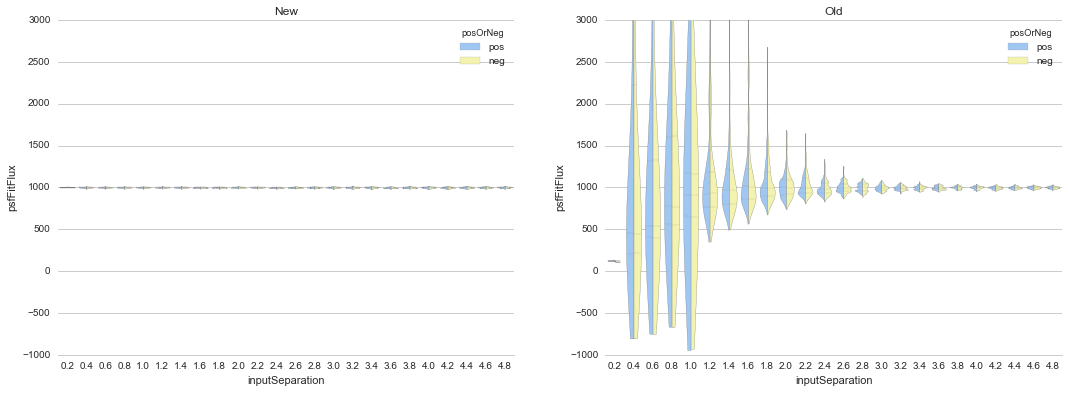

In [ ]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results2])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.3, bw=0.2, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results2])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df1.loc[(df1.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
df2.loc[(df2.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.3, bw=0.2, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-1000,3000])
axes[1].set_title('Old')
axes[1].set_ylim([-1000,3000])

## Different dipole fluxes (signal-to-noise) AND orientations AND separations

In [ ]:
varNames = genDipoleAndFitBothWays.__code__.co_varnames[:genDipoleAndFitBothWays.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)
fluxes = np.arange(250., 6000., 250.)
n_reps = 10

inputs = [varTuple(w=51, h=51, xc=25., yc=25., psfSigma=2.0, separation=sep, rotAngle=rot, 
                    flux=flux, noise=1., tol=1e-7, rel_weight=0.5, 
                   gradientParams=(1., 3., 7.), verbose=False, display=False) 
                for i in xrange(n_reps) for flux in fluxes for rot in orientations for sep in separations]
print len(inputs)

def processInput(i):
    output = genDipoleAndFitBothWays(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfSigma=i.psfSigma, 
                                     separation=i.separation, rotAngle=i.rotAngle, flux=i.flux, 
                                     noise=i.noise, tol=i.tol, rel_weight=i.rel_weight, 
                                     gradientParams=i.gradientParams, verbose=False, display=False)
    if output['new'] is not None:
        output['new'] = output['new']._asdict()
    if output['old'] is not None:
        output['old'] = output['old']._asdict()
    return {'old': output['old'], 'new': output['new']} ## don't need the images returned
 
num_cores = multiprocessing.cpu_count() / 2
#results3 = [processInput(i) for i in inputs]
results3 = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

55200


In [ ]:
## NOT RUN:
#if False:
import cPickle as pickle
import gzip
pickle.dump((results, results2, results3), gzip.GzipFile("results_8j.p.gz", "wb"))

In [ ]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results3])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['rmsCentroid'] = np.sqrt((df2.inputNegCentroidX - df2.psfFitNegCentroidX)**2. + \
                               (df2.inputNegCentroidY - df2.psfFitNegCentroidY)**2.)   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="rmsCentroid", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.1, bw=0.1, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results3])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['rmsCentroid'] = np.sqrt((df2.inputNegCentroidX - df2.psfFitNegCentroidX)**2. + \
                               (df2.inputNegCentroidY - df2.psfFitNegCentroidY)**2.)   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="rmsCentroid", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.1, bw=0.1, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-0.05,0.8])
axes[1].set_title('Old')
axes[1].set_ylim([-0.05,0.8])

In [ ]:
##### matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results3])
#df1 = df1.loc[(df1.inputFlux == 5000.)]
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=0.25, linewidth=0.1, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results3])
#df1 = df1.loc[(df1.inputFlux == 5000.)]
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
#df1.loc[(df1.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
#df2.loc[(df2.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=0.25, linewidth=0.1, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-1000,15000])
axes[1].set_title('Old')
axes[1].set_ylim([-1000,15000])

In [ ]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results3])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputFlux", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=0.1, linewidth=0.1, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results3])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
#df1.loc[(df1.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
#df2.loc[(df2.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputFlux", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=0.1, linewidth=0.1, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([0,7000])
axes[1].set_title('Old')
axes[1].set_ylim([0,7000])

In [ ]:
df1 = pd.DataFrame([res['new'] for res in results3])
df2 = pd.DataFrame([res['old'] for res in results3])
df = pd.DataFrame({'new': df1['psfFitPosFlux'], 'old': df2['psfFitPosFlux'], 'fl': df1['inputFlux']})
df = df[(df['new'] != np.inf) & (df['old'] != np.inf)] # & (df['sn1'] < 30000.) & (df['sn2'] < 30000.)]
ax = df.plot(x='new', y='old', kind='scatter', c=df['fl']/df['fl'].max(), s=5.)
ax.set_xlim([-100,6500])
ax.set_ylim([-100,6500])

In [ ]:
df = pd.DataFrame([res['new'] for res in results3])
df['newOrOld'] = np.repeat('new', df.shape[0])
df['log10psfFitSignalToNoise'] = np.log10(df['psfFitSignaltoNoise'])
df = df[(df.log10psfFitSignalToNoise != np.inf) & (df.log10psfFitSignalToNoise != np.nan) & (df.log10psfFitSignalToNoise < 8000.)]

df2 = pd.DataFrame([res['old'] for res in results3])
df2['newOrOld'] = np.repeat('old', df2.shape[0])
df2['log10psfFitSignalToNoise'] = np.log10(df2['psfFitSignaltoNoise'])
df2 = df2[(np.abs(df2.log10psfFitSignalToNoise) != np.inf) & (df2.log10psfFitSignalToNoise != np.nan) & (df2.log10psfFitSignalToNoise < 8000.)]

df = df.append(df2)

matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
#fig, axes = plt.subplots(nrows=1, ncols=2)
fig = plt.figure()
ax = fig.add_subplot(111)

sns.violinplot(x="inputFlux", y="log10psfFitSignalToNoise", hue="newOrOld", data=df, split=True,
               inner="quart", palette={"new": "b", "old": "y"}, cutoff=True, bw=0.2, axis=ax)
sns.despine(left=True)
ax.set_ylim([-0.5,3.])

## Investigate error contours by including (or not) the pre-subtracted image planes in the fit and including (or not) the background gradients

In [ ]:
xc=25.; yc=25.; separation=0.4; rotAngle=324.

rotAngRad = rotAngle / 180. * np.pi
sep = separation / 2.
xcenPos, ycenPos = xc+sep*np.cos(rotAngRad), yc+sep*np.sin(rotAngRad)
xcenNeg, ycenNeg = xc-sep*np.cos(rotAngRad), yc-sep*np.sin(rotAngRad)

diffim, (posImage, posCatalog), (negImage, negCatalog) = \
    dtUtils.DipoleTestUtils.makeDipoleImage(w=51, h=51, xcenPos=[xcenPos], ycenPos=[ycenPos], \
                         xcenNeg=[xcenNeg], ycenNeg=[ycenNeg], \
                         psfSigma=2., flux=[5000.], noise=1., \
                        gradientParams=(1., 3., 7.))

dft.DipolePlotUtils.displayExposure(diffim)
dft.DipolePlotUtils.displayExposure(posImage)
dft.DipolePlotUtils.displayExposure(negImage)

s = dtUtils.DipoleTestUtils.detectDipoleSources(diffim, doMerge=True)

### Plot confidence intervals...

see https://lmfit.github.io/lmfit-py/confidence.html

In [ ]:
## hide warnings for this fit.
import warnings
warnings.filterwarnings('ignore')

def plot_conf_intervals(result):
    ci, trace = lmfit.conf_interval(result, result, sigmas=[0.68,0.95],
                                    trace=True, verbose=False)
    lmfit.printfuncs.report_ci(ci)

    cx, cy, grid = lmfit.conf_interval2d(result, result, 'xcenPos','flux', 30, 30)
    plt.subplot(1, 2, 1)
    plt.contourf(cx, cy, grid, np.linspace(0,1,100))
    plt.xlabel('xcenPos')
    plt.ylabel('flux')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    cx, cy, grid = lmfit.conf_interval2d(result, result, 'xcenPos','ycenPos', 30, 30)
    plt.contourf(cx, cy, grid, np.linspace(0,1,100))
    plt.xlabel('xcenPos')
    plt.ylabel('ycenPos')
    plt.colorbar() 

First, don't include pre-subtracted data (weight=0)

In [ ]:
_, result0 = dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, tol=1e-7, rel_weight=0.,
                           separateNegParams=False, verbose=False, display=False, return_fitObj=True)
plot_conf_intervals(result0)

Now, with the pre-subtraction data weighted at 5% of the subtracted data:

In [ ]:
_, result1 = dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, tol=1e-7, rel_weight=0.05, 
                           separateNegParams=False, verbose=False, display=False, return_fitObj=True)
plot_conf_intervals(result1)

Finally with the pre-subtraction data weighted equally with the diffim data...

In [ ]:
_, result2 = dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, tol=1e-7, rel_weight=0.5, 
                           separateNegParams=False, verbose=False, display=False, return_fitObj=True)
plot_conf_intervals(result2)

Lastly with the pre-subtraction data weighted 1/20 $\times$ the diffim data but no background gradient included in the fits. Note we include a background constant just because we need it.

In [ ]:
_, result3 = dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, tol=1e-7, rel_weight=0.05, 
                           separateNegParams=False, bgGradientOrder=0, verbose=False, display=False, return_fitObj=True)
plot_conf_intervals(result3)

Lastly with the pre-subtraction data weighted 1/2 $\times$ (standard) the diffim data but no background gradient included in the fits. Note we include a background constant just because we need it.

In [ ]:
_, result4 = dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, tol=1e-7, rel_weight=0.5, 
                           separateNegParams=False, bgGradientOrder=0, verbose=False, display=False, return_fitObj=True)
plot_conf_intervals(result4)